# Import Packages

In [1]:
import sys, os, pdb, glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table, join, MaskedColumn
from astroquery.vizier import Vizier
import warnings
from astropy.logger import AstropyWarning
warnings.filterwarnings('ignore', category=AstropyWarning)

# Define Functions

In [2]:
def get_data(catalog, join_key='Name', join_type='inner'):

    """
    PURPOSE:    Get data from literature with Vizier

    INPUT:      catalog = ctalog name on Vizier (str)
                join_key = column header to join tables, if multiple (str; optional)
                join_type = way to join tables, if multiple (str; optional)

    OUTPUT:     t = data table (AstroPy Table)

    """

    ### GET FULL CATALOG (ALL COLUMNS, ALL ROWS)
    viz = Vizier(catalog=catalog, columns=['**'])
    viz.ROW_LIMIT = -1
    tv = viz.get_catalogs(catalog)

    ### IF MULTIPLE TABLES, JOIN THEM
    for i, val in enumerate(tv.keys()):
        if i == 0:
            t = tv[val]
        else:
            tt = tv[val]
            if join_key in tt.columns:
                t = join(t, tt, join_type=join_type, keys=join_key)

    return t

In [ ]:
def spt_coding(spt):

    """
    PURPOSE:    Translate spectral type (e.g., M7) into numerical value
                that can be used for plotting a histogram

                Scale is 0 at M0, -1 at K7, -8 at K0, -18 at G0
                (K8 is counted as M0)

    INPUT:      spt = numpy array of spectral types (str, masked)
                (masked values are unknonw spectral types)

    OUTPUT:     spt_num = numpy array of numerical spectral types (obj, masked)
                (returns -99. if unknown spectral type)
    
    """

    spt_num = np.empty(len(spt), dtype=object)
    for i, val in enumerate(spt):

        if val == '':
            spt_num[i] = -99.

        else:

            if val == 'M1+M2':
                val = 'M1.5'
            if val[0] == 'M':
                spt_num[i] = float(val[1:])
            if val[0] == 'K':
                spt_num[i] = float(val[1:]) - 8.
            if val[0] == 'G':
                spt_num[i] = float(val[1:]) - 18.
            if val[0] == 'F':
                spt_num[i] = float(val[1:]) - 28.
            if val[0] == 'A':
                spt_num[i] = float(val[1:]) - 38.
 
    return spt_num

# Code

Load in Lupus data

In [3]:
T = get_data("J/AJ/153/240", join_type='outer')

Flag undetected sources

Note: Used 2.0 because online table decimal places cutoff to make < 3.0

In [4]:
T.add_column(MaskedColumn(name='Detected', data=T['F1.33']/T['e_F1.33'] >= 2.9))

Get spactral type coding for plotting (all, non-detections, unobserved)

In [5]:
Spt_All = spt_coding(T['SpT'])
Spt_Det = spt_coding(T['SpT'][np.where(T['Detected'])])

Create plot

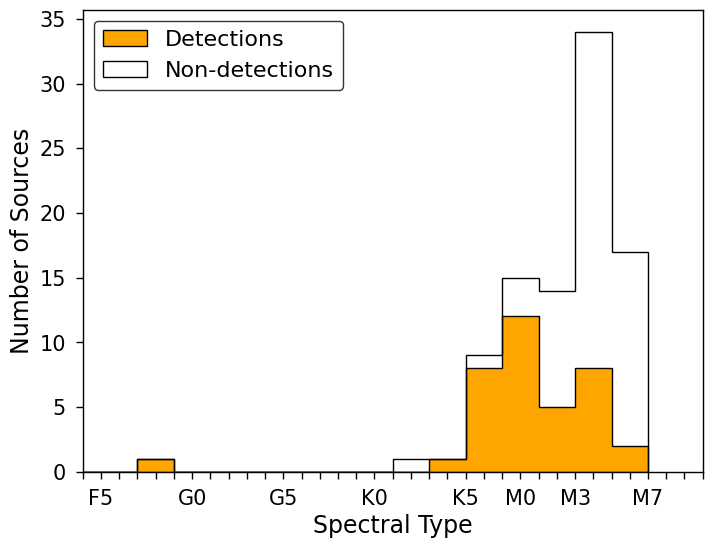

In [6]:
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
mpl.rc('xtick.major', size=5, pad=7, width=1)
mpl.rc('ytick.major', size=5, pad=7, width=1)
mpl.rc('axes', linewidth=1)
mpl.rc('lines', markersize=5)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_xlabel('Spectral Type', fontsize=17)
ax.set_ylabel("Number of Sources", fontsize=17)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
nxticks    = np.arange(-25, 10, 1)
ticklabels = np.array(['', 'F5', '', '', '', '', 'G0', '', '', '', '', 'G5', '', '', '', '',
                        'K0', '', '', '', '', 'K5', '', '', 'M0', '', '', 'M3', '', '', '', 'M7', '', '', ''])
ax.set_xticks(nxticks)
ax.set_xticklabels(ticklabels)
ax.set_xlim(np.min(nxticks), np.max(nxticks))
# ax.set_ylim(0, 25)

### PLOT DIFFERENT SAMPLES
bins_spt = np.arange(-33, 9, 2)
ax.hist(Spt_Det, bins_spt, align='left', lw=1, histtype='stepfilled', facecolor='orange', edgecolor='black', label='Detections')
ax.hist(Spt_All, bins_spt, align='left', color='black', lw=1, histtype='step', label='Non-detections')
ax.legend(loc='upper left', prop={'size': 16}, edgecolor='black')

Save figure

In [7]:
fig.savefig('../output/figure_01.png', bbox_inches='tight', dpi=100)
plt.close('all')